In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [22]:
model_names = [

    # "ew_lo_small_sample",
    # "mvo_ls_small_sample_mle_mle", "mvo_ls_small_sample_nobb_nobb", "mvo_ls_small_sample_cbb_cbb", "mvo_ls_small_sample_sb_sb"
    # "md_ls_small_sample_mle", "md_ls_small_sample_nobb", "md_ls_small_sample_cbb", "md_ls_small_sample_sb"
    "rpo_ls_small_sample_mle_mle_cs2006", "rpo_ls_small_sample_nobb_nobb_cs2006", "rpo_ls_small_sample_cbb_cbb_cs2006", "rpo_ls_small_sample_sb_sb_cs2006"

]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [23]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [24]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
rpo_ls_small_sample_mle_mle_cs2006,1.100626,2.529482,0.435119,0.608464,-0.834343,-2.997720,0.502804
rpo_ls_small_sample_nobb_nobb_cs2006,-1.839546,2.388009,-0.770326,-1.058282,-3.878107,-8.217437,0.472897
rpo_ls_small_sample_cbb_cbb_cs2006,-0.371691,2.434412,-0.152682,-0.208400,-2.540875,-5.918952,0.490654
rpo_ls_small_sample_sb_sb_cs2006,0.380192,2.667194,0.142544,0.205513,-2.177394,-4.267807,0.497196


In [25]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
                               index &      E[R] &   Std(R) &    Sharpe &   Sortino &     AvgDD &     MaxDD &  \% Positive Ret. \\
\midrule
  rpo\_ls\_small\_sample\_mle\_mle\_cs2006 &  1.100626 & 2.529482 &  0.435119 &  0.608464 & -0.834343 & -2.997720 &         0.502804 \\
rpo\_ls\_small\_sample\_nobb\_nobb\_cs2006 & -1.839546 & 2.388009 & -0.770326 & -1.058282 & -3.878107 & -8.217437 &         0.472897 \\
  rpo\_ls\_small\_sample\_cbb\_cbb\_cs2006 & -0.371691 & 2.434412 & -0.152682 & -0.208400 & -2.540875 & -5.918952 &         0.490654 \\
    rpo\_ls\_small\_sample\_sb\_sb\_cs2006 &  0.380192 & 2.667194 &  0.142544 &  0.205513 & -2.177394 & -4.267807 &         0.497196 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

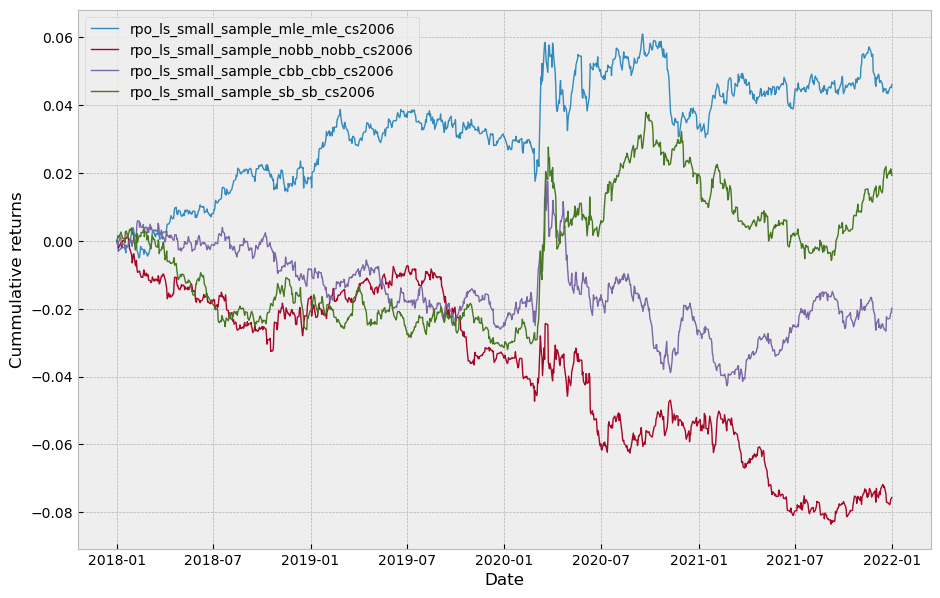

In [26]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2018-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test